# LIFE Star Catalog
## Introduction
One of the main use cases of the LIFE Target Database is to enable the creation of the LIFE Star Catalog (LIFE-StarCat). It is the stellar sample of potential targets that is used by LIFEsim to provide mission yield estimates. In this tutorial we guide you through how the 4th version of this catalog was created. Following our example you can learn how you could create your own catalog for your science project.

 __Important: If you just want to access the latest version of the Star Catalog go to  [LIFE-StarCat4](https://drive.google.com/file/d/12F7N0w3kGHJw3FBbf_P6xF9Pers38wbu/view?usp=sharing).__

## File location
Make sure to run this file in the correct location (data_generation/life_td_data_generation/catalog). The file in data_generation/docs/source/tutorials is only intended for proper display on the webpage. Alternatively you can adapt the paths to the modules and saving locations.

## Getting started
We start by importing the required Python modules for this tutorial. Be aware that you will need to have them installed in your environment for this to work.

In [75]:
import astropy as ap  # Used for votables
import numpy as np  # Used for arrays
import pyvo as vo  # Used for catalog query

Next we import the life_td_data_generation specific functions from the modules.

In [76]:
# Self created modules
from provider.utils import query
from utils.io import save, objecttostring

In case you don't want to download the life_td_data_generation package you can also just use the two functions below. Be aware in that case you might need to adjust the paths for saving of the catalog and the plotting functions won't work.

In [3]:
def objecttostring(cat):
    for i in cat.colnames:
        if cat[i].dtype == object:  # object =adaptable length string
            # transform the type into string
            cat[i] = cat[i].astype(str)
    return cat


def query(link, query, catalogs=[], no_description=True):
    """
    Performs a query via TAP on the service given in the link parameter.

    If a list of tables is given in the catalogs parameter,
    those are uploaded to the service beforehand.

    :param str link: Service access URL.
    :param str query: Query to be asked of the external database service
         in ADQL.
    :param catalogs: List of astropy tables to be uploaded to the
        service.
    :type catalogs: list(astropy.table.table.Table)
    :param bool no_description: Defaults to True, wether description gets removed
    :returns: Result of the query.
    :rtype: astropy.table.table.Table
    """
    # defining the vo service using the given link
    service = vo.dal.TAPService(link)
    # without upload tables
    if catalogs == []:
        result = service.run_sync(query.format(**locals()), maxrec=1600000)
    # with upload tables
    else:
        tables = {}
        for i in range(len(catalogs)):
            tables.update({f"t{i + 1}": catalogs[i]})
        result = service.run_sync(
            query, uploads=tables, timeout=None, maxrec=1600000
        )
    cat = result.to_table()

    # removing descriptions because merging of data leaves wrong description
    for col in cat.colnames:
        if no_description:
            cat[col].description = ""

    return cat

## Querying the Database
We will now query the LIFE Target Database (life_td) for the data needed to create the catalog. We specify the distance cut as 30 parsec according to the latest LIFE catalog version (4).

In [77]:
distance_cut = 30.0

Now we define the concrete query. It is one of the provided examples at http://dc.zah.uni-heidelberg.de/life/q/ex/examples and returns parameters for all objects of type star with distances smaller than 30 pc. We also give the link for the service.

In [78]:
adql_query = """
    SELECT o.main_id, sb.coo_ra, sb.coo_dec, sb.sptype_string,
        sb.plx_value, sb.dist_st_value, sb.coo_gal_l, sb.coo_gal_b,
        sb.teff_st_value, teff_source.ref AS teff_ref,
        sb.mass_st_value, mass_source.ref AS mass_ref,
        sb.radius_st_value, radius_source.ref AS radius_ref,
        sb.binary_flag, binary_source.ref AS binary_ref,
        sb.mag_i_value, sb.mag_j_value, sb.class_lum, sb.class_temp,
        o_parent.main_id AS parent_main_id, sb_parent.sep_ang_value
    FROM life_td.star_basic AS sb
    JOIN life_td.object AS o ON sb.object_idref=o.object_id
    LEFT JOIN life_td.h_link AS h ON o.object_id=h.child_object_idref
    LEFT JOIN life_td.object AS o_parent ON
        h.parent_object_idref=o_parent.object_id
    LEFT JOIN life_td.star_basic AS sb_parent ON
        o_parent.object_id=sb_parent.object_idref
    LEFT JOIN life_td.source AS radius_source ON
        sb.radius_st_source_idref=radius_source.source_id
    LEFT JOIN life_td.source AS mass_source ON
        sb.mass_st_source_idref=mass_source.source_id
    LEFT JOIN life_td.source AS teff_source ON
        sb.teff_st_source_idref=teff_source.source_id
    LEFT JOIN life_td.source AS binary_source ON
        sb.binary_source_idref=binary_source.source_id
    WHERE o.type = 'st' AND sb.dist_st_value < """ + str(distance_cut)
#service = "http://dc.zah.uni-heidelberg.de/tap"
service = "http://dc.g-vo.org/tap"

Next we perform the actual query.

Note: If you use the query function through the import and it takes long (<1min) that is because that function uses the asynchroneous modus which can take longer if there are many big queries on the same server. In that case instead run the cell with the query function written out instead of imported. It uses the synchroneous modus.

In [79]:
catalog = query(service, adql_query)

Let's have a short look at what we got:

In [80]:
print(catalog)

       main_id               coo_ra       ... parent_main_id sep_ang_value
                              deg         ...                    arcsec   
---------------------- ------------------ ... -------------- -------------
           *  61 Cyg B  316.7302660185276 ...      *  61 Cyg          17.5
           *  61 Cyg A  316.7247482895925 ...      *  61 Cyg          17.5
          BD+40   883A  315.0224464400413 ...    BD+40   883           1.0
           L 1578-44 B  324.1601460120721 ...      L 1578-44           1.0
           L 1578-44 A 324.16073469423293 ...      L 1578-44           1.0
       UPM J2325+4717B  351.4090302929913 ... UPM J2325+4717            --
       UPM J2325+4717A  351.4091812460812 ... UPM J2325+4717            --
            Ross  200B  325.0050669305063 ...      Ross  200           1.2
            Ross  200A  325.0044367358217 ...      Ross  200           1.2
                   ...                ... ...            ...           ...
             HD  39071   

We can see that we obtained a table of about 10'000 stars.

## Processing the result
### Flagging non main-sequence stars
For the LIFE mission we are only interested in main sequence stars so in the next step we flag all other stars. We first consider non main sequence temperature classes (e.g. white dwarfs).

In [81]:
ms_tempclass = np.array(["O", "B", "A", "F", "G", "K", "M"])

catalog["ms_temp_class"] = np.where(np.isin(catalog["class_temp"], ms_tempclass), "True", "False")

print(catalog["main_id","class_temp","ms_temp_class"])

       main_id         class_temp ms_temp_class
---------------------- ---------- -------------
           *  61 Cyg B          K          True
           *  61 Cyg A          K          True
          BD+40   883A          M          True
           L 1578-44 B                    False
           L 1578-44 A          M          True
       UPM J2325+4717B                    False
       UPM J2325+4717A                    False
            Ross  200B                    False
            Ross  200A                    False
            HD 239960B          M          True
                   ...        ...           ...
             HD  39071          K          True
            LP  745-67                    False
2MASSW J1338261+414034                    False
            LEHPM 5537                    False
             HD  62848          F          True
  CFBDS J030135-161418                    False
             Wolf 1014          M          True
              G 130-14          M       

Next we consider objects that are not main sequence in luminosity class.
Note that the class_lum parameter from the LIFE Target Database assumes V if no luminosity class is given in the sptype_string parameter. This is justified as the main sequence is the longest lasting evolutionary period of a star leaving the great majority of stars in this stage. This assumption was previously neccessary as the in previous LIFE-StarCat versions estimated stellar effective temperature, mass and radius values use a relation requiring luminosity class V.

In [82]:
ms_lumclass = np.array(["V"])

catalog["ms_lum_class"] = np.where(np.isin(catalog["class_lum"], ms_lumclass), "True", "False")

print(catalog["main_id","class_lum","ms_lum_class"])

       main_id         class_lum ms_lum_class
---------------------- --------- ------------
           *  61 Cyg B         V         True
           *  61 Cyg A         V         True
          BD+40   883A         V         True
           L 1578-44 B                  False
           L 1578-44 A         V         True
       UPM J2325+4717B                  False
       UPM J2325+4717A                  False
            Ross  200B                  False
            Ross  200A                  False
            HD 239960B         V         True
                   ...       ...          ...
             HD  39071         V         True
            LP  745-67                  False
2MASSW J1338261+414034                  False
            LEHPM 5537                  False
             HD  62848         V         True
  CFBDS J030135-161418                  False
             Wolf 1014         V         True
              G 130-14         V         True
            LP  860-46         V  

Now for the final catalog we want to have stellar mass values for each object. Currently the database is not able to assign model masses to some of the spectral types. This is the case when something like M or M (3) V is given in sptype_string. This will be implemented in one of the future database releases but for now we will just flag all objects without entries in mass_st_value.

In [83]:
catalog["mass_flag"] = np.invert(catalog["mass_st_value"].mask)

print(catalog["main_id","mass_st_value","mass_flag"])

       main_id           mass_st_value    mass_flag
                            solMass                
---------------------- ------------------ ---------
           *  61 Cyg B               0.64      True
           *  61 Cyg A 0.6795274019241333      True
          BD+40   883A               0.44      True
           L 1578-44 B                 --     False
           L 1578-44 A               0.54      True
       UPM J2325+4717B                 --     False
       UPM J2325+4717A                 --     False
            Ross  200B                 --     False
            Ross  200A                 --     False
                   ...                ...       ...
             HD  39071               0.86      True
            LP  745-67                 --     False
2MASSW J1338261+414034                 --     False
            LEHPM 5537                 --     False
             HD  62848 1.0661697387695312      True
  CFBDS J030135-161418                 --     False
            

### Flagging higher order multiples
For the LIFE catalog we want single stars and wide binaries that can be approximated as single stars. For that we now split the sample into single and multiple stars:

In [84]:
singles = catalog[np.where(catalog["binary_flag"] == "False")]
multiples = catalog[np.where(catalog["binary_flag"] == "True")]
print(len(singles), len(multiples))

6099 2968


Next we flag higher order multiples. That means we flag systems like shown in the nextled multiples part of the following figure:
![title](multiplicity.png)

To do that we first flag those objects, where the parent object is a child object as well. In the example above that would be "system AB". For that we need to get the hierarchy table from life_td.

In [85]:
adql_query2 = """
    SELECT o.main_id as child_main_id,o.object_id
    FROM life_td.object AS o
    JOIN life_td.h_link AS h on o.object_id=h.child_object_idref
    """
h_link = query(service, adql_query2)

In [86]:
multiples["higher_order_multiples"] = np.isin(
    multiples["parent_main_id"], h_link["child_main_id"]
)
print(multiples["higher_order_multiples"]==False)

[ True  True  True ...  True  True  True]


Now we also flag objects that have multiple parent objects, e.g., *  9 Aur has as parent WDS J05067+5136AB, WDS J05067+5136AC and WDS J05067+5136AE given.

In [112]:
def sorting_number_of_id(input_column,occurences,match_column):
    unique_id,number_of_repetitions=np.unique(
        input_column,return_counts=True)
    subset=unique_id[number_of_repetitions==occurences]
    flag_array=np.isin(match_column,subset)
    return flag_array

multiples["single_parent"] = sorting_number_of_id(
    multiples["main_id"],1,multiples["main_id"])

print(multiples["main_id","single_parent"])
print(multiples["main_id","single_parent"][np.where(multiples["main_id"]=="*   9 Aur")]) # try once new db is published and see if still not found

        main_id         single_parent
----------------------- -------------
            *  61 Cyg B          True
            *  61 Cyg A          True
           BD+40   883A          True
            L 1578-44 B          True
            L 1578-44 A          True
        UPM J2325+4717B          True
        UPM J2325+4717A          True
             Ross  200B          True
             Ross  200A          True
             HD 239960B          True
                    ...           ...
2MASS J22521073-1730134          True
            BD+55  1823          True
      BPS CS 31060-0015          True
              HD 146946          True
            CD-35  2722          True
          TYC 5060-53-1          True
            BD+11  2874          True
            * 111 Tau B          True
                * b Her          True
            LP  495-189          True
Length = 2968 rows
main_id single_parent
------- -------------


In [113]:
#kick out stuff like *  61 Cyg A , B, and C who all have parent *  61 Cyg
binaries_in_multiples_table = sorting_number_of_id(
    multiples["parent_main_id"],2,multiples["parent_main_id"])
print(binaries_in_multiples_table)

[ True  True False ... False False False]


In [114]:
multiples["trivial_binaries"] = (
    (multiples["higher_order_multiples"]==False)
    & multiples["single_parent"]
    & binaries_in_multiples_table
)

In [115]:
print(multiples["trivial_binaries"])

trivial_binaries
----------------
            True
            True
           False
            True
            True
            True
            True
            True
            True
            True
             ...
           False
           False
           False
           False
           False
           False
           False
           False
           False
           False
Length = 2968 rows


Since we want to get wide binaries the next step is to have a look at the given separation values. We flag those binaries where no separation value is given.

In [116]:
multiples["sep_flag"] = np.invert(multiples["sep_ang_value"].mask)

print(multiples["main_id","sep_ang_value","sep_flag"])

        main_id         sep_ang_value sep_flag
                            arcsec            
----------------------- ------------- --------
            *  61 Cyg B          17.5     True
            *  61 Cyg A          17.5     True
           BD+40   883A           1.0     True
            L 1578-44 B           1.0     True
            L 1578-44 A           1.0     True
        UPM J2325+4717B            --    False
        UPM J2325+4717A            --    False
             Ross  200B           1.2     True
             Ross  200A           1.2     True
                    ...           ...      ...
2MASS J22521073-1730134            --    False
            BD+55  1823            --    False
      BPS CS 31060-0015            --    False
              HD 146946            --    False
            CD-35  2722            --    False
          TYC 5060-53-1            --    False
            BD+11  2874            --    False
            * 111 Tau B            --    False
             

Now we transform the separation values from angular into physical. This is neccessary as we want to look at in a later step at the planetery orbit stability around the habitable zone.

In [117]:
multiples["sep_phys_value"] = multiples[
    "sep_ang_value"
]  # just initiating new column with same properties
multiples["sep_phys_value"].unit = ap.units.AU
for i in range(len(multiples)):
    if multiples["sep_flag"][i] == "True":
        multiples["sep_phys_value"][i] = np.round(
            multiples["sep_ang_value"][i] * multiples["dist_st_value"][i], 1
    )

Now we flag those binaries where both components fulfill all our requirements. Meaning the posses the parameters we need to compute the orbital stability mentioned above. Those parameters are being main sequence having the separation value given.

In [118]:
multiples["final_flag"] = (
    multiples["sep_flag"]
    & (multiples["ms_temp_class"] == "True")
    & (multiples["ms_lum_class"] == "True")
    & multiples["mass_flag"]
    & multiples["trivial_binaries"]
)
print(multiples["main_id","sep_flag","ms_temp_class","ms_lum_class","mass_flag","trivial_binaries","final_flag"])

        main_id         sep_flag ms_temp_class ... trivial_binaries final_flag
----------------------- -------- ------------- ... ---------------- ----------
            *  61 Cyg B     True          True ...             True       True
            *  61 Cyg A     True          True ...             True       True
           BD+40   883A     True          True ...            False      False
            L 1578-44 B     True         False ...             True      False
            L 1578-44 A     True          True ...             True       True
        UPM J2325+4717B    False         False ...             True      False
        UPM J2325+4717A    False         False ...             True      False
             Ross  200B     True         False ...             True      False
             Ross  200A     True         False ...             True      False
             HD 239960B     True          True ...             True       True
                    ...      ...           ... ...  

In [119]:
#final flag for both companions to form suitable companion pair
multiples["suitable_companions"] = sorting_number_of_id(
    multiples["parent_main_id"][multiples["final_flag"]],
    2,multiples["parent_main_id"])


In [120]:
print(len(multiples[multiples["suitable_companions"] == True]))# should be around 418

412


### Wide binaries
Now we actually focus on the wide binaries. This means we look at objects where <10 AU planet orbits are stable. For that we use the formula from Holman and Wiegert 1999 while assuming circular orbits and neglect projection effects of the bianry separations.
The following function computes the critical separation beyond which a planet on a S-type orbit is not stable any more.

In [19]:
def crit_sep(eps, mu, a_bin):
    """
    Computes critical semimajor-axis for planet orbit stability.

    For binary system as described in Holman and Wiegert 1999.

    :param eps: Binary orbit excentricity.
    :type eps:
    :param mu: mass fraction with mu=m_s/(m_p+m_s), with m_s the mass
        of the star considered as perturbing binary companion and m_p
        the mass of the star the planet is orbiting.
    :type mu:
    :param a_bin: semimajor-axis of the binary stars.
    :type a_bin:
    :returns: Critical separation beyond which a planet on a S-type
        orbit (circumstellar) and on a P-type orbit (circumbinary) is
        not stable any more.
    :rtype:
    """
    a_crit_s = (
        0.464
        - 0.38 * mu
        - 0.631 * eps
        + 0.586 * mu * eps
        + 0.15 * eps**2
        - 0.198 * mu * eps**2
    ) * a_bin
    a_crit_p = (
        1.6
        + 5.1 * eps
        - 2.22 * eps**2
        + 4.12 * mu
        - 4.27 * eps * mu
        - 5.09 * mu**2
        + 4.61 * eps**2 * mu**2
    ) * a_bin
    return a_crit_s, a_crit_p

Now we assign the critical separation to each binary component.

In [ ]:
#issue: order is not correct. needs to be sorted by parent_main_id


In [ ]:
result["a_crit_s"] = result[
    "sep_phys_value"
]  # initializing column a... like sep...

for i in range(len(result)):
    m_p = result["mass_st_value"][i]
    if i % 2 == 0:
        m_s = result["mass_st_value"][i + 1]
    else:
        m_s = result["mass_st_value"][i - 1]
    mu = m_s / (m_p + m_s)
    result["a_crit_s"][i] = crit_sep(0, mu, result["sep_phys_value"][i])[0]
    # assumed circular orbit and sep_phys = a_bin

Next we keep only those where orbits up to 10AU are stable.

In [21]:
final = result[:0].copy()
# wait, didn't I already define this? -> was before removing some
ind = result.group_by("parent_main_id").groups.indices
a_max = 10.0

for i in range(len(ind) - 1):
    if a_max < min(result["a_crit_s"][ind[i]], result["a_crit_s"][ind[i] + 1]):
        final.add_row(result[ind[i]])
        final.add_row(result[ind[i] + 1])

In [22]:
print(len(final))

374


Finally we combine the singles stars and wide binaries back into a single sample.

In [23]:
StarCat4 = ap.table.vstack([singles, final])

### Adding architecture parameter
For mission design trade space we are interested in the ability to take subsamples of the stars depending on ecliptic angle. We therefore add another parameter indicating if the given star is within 45 degrees from the ecliptic plane.

In [24]:
def ecliptic(ang, ra, dec):
    """
    Computes if position is within angle from the ecliptic.

    Flag any object whose declination is contained within the region
    between -(23.4+angle)*sin(RA) and +(23.4+angle)*sin(RA) with the
    object's RA in degrees.

    :param ang: Angle in degrees.
    :type ang:
    :param ra: Right ascention in degrees.
    :type ra: np.array
    :param dec: Array of declination in degrees.
    :type dec: np.array
    :returns: Flags.
    :rtype: np.array
    """
    ecliptic = (23.4) * np.sin(2 * np.pi * ra / 360)
    flag = [
        "True"
        if dec[j] > -ang + ecliptic[j] and dec[j] < ang + ecliptic[j]
        else "False"
        for j in range(len(ra))
    ]
    return flag


StarCat4["ecliptic_pm45deg"] = ecliptic(
    45, StarCat4["coo_ra"], StarCat4["coo_dec"]
)

Let's have a last look at our final catalog and then save the table.

In [25]:
print(StarCat4)

        main_id               coo_ra       ... ecliptic_pm45deg
                               deg         ...                 
----------------------- ------------------ ... ----------------
            BD-12   662  52.33246607947125 ...             True
            LP 1032-116  335.4571804690921 ...             True
               G 138-37 247.89607291868327 ...             True
               G 144-64  316.8518218343254 ...             True
               G 141-10    276.60248715442 ...             True
            CD-22 13916 291.14264684284916 ...             True
              LP  759-6    329.30281861144 ...             True
        SIPS J2049-1944  312.3322935777066 ...             True
         PM J11523+1640    178.08549480447 ...             True
                    ...                ... ...              ...
            BD-20  6558 348.56928489779494 ...             True
           BD-20  6558B 348.56858731544924 ...             True
             LP  704-14    359.330662567

This next line is to convert data from object into string type. I use object as default because it prevents data getting truncated. Though it does have issues with the astropy ecsv format.


In [26]:
StarCat4=objecttostring(StarCat4)

In [27]:
StarCat4.write(
        "../../../additional_data/catalogs/StarCat4.ecsv",delimiter=",",
        overwrite=True
    )

We can also look at the distance and spectral type distribution to make sure it looks reasonable.

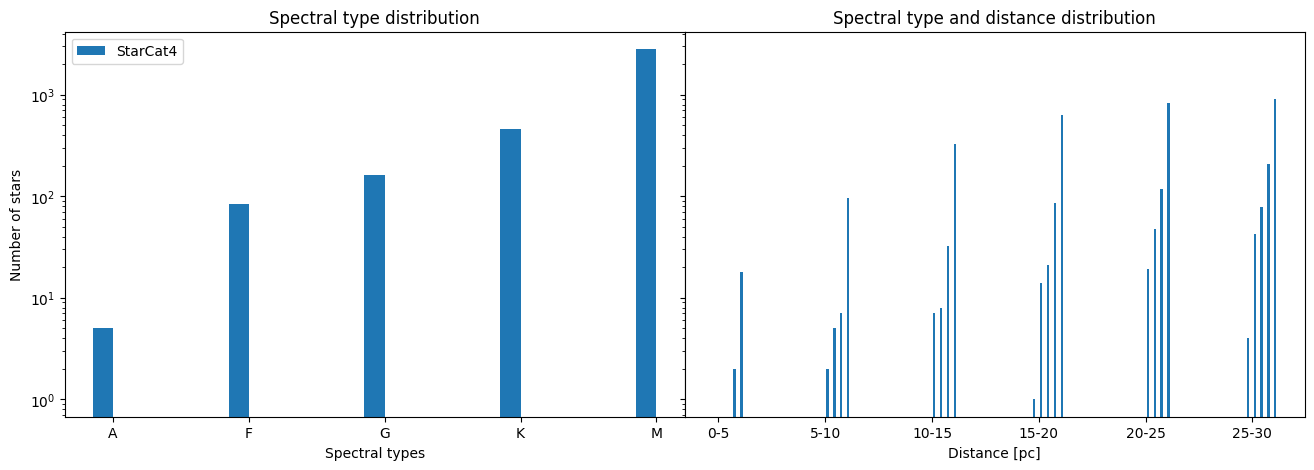

In [28]:
from utils.analysis.finalplot import starcat_distribution_plot

starcat_distribution_plot(
    [StarCat4["class_temp", "dist_st_value"]], ["StarCat4"],
    path= "../../../plots/final_plot.png"
)

We can observe that the spectral type distribution looks as expected meaning the lower the mass of the star the more of them are within 30pc. We also see that within 20 pc we only have M and K stars in our sample. Also the spectral type distribution of the stars in our catalog between 20-25pc are nearly identical to the ones between 25-30pc. We would expect there to be way more lower mass stars in the further away distance bin. This let's us conclude that at the end of the distance cut our catalog is magnitude limited meaning we miss quite a bit of the faint stars.

To have a look at the data using the same plot as in the RNAAS article use the code below.

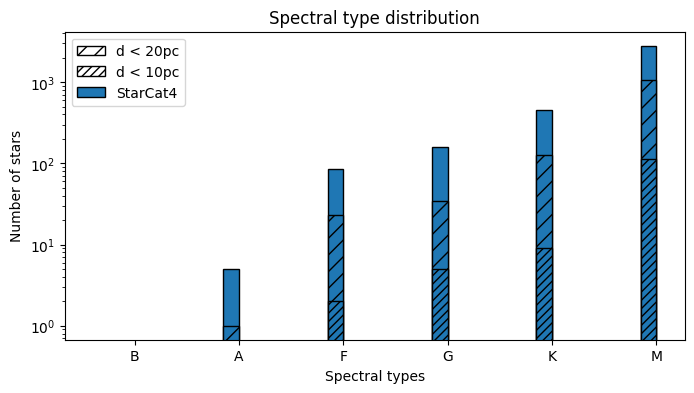

In [29]:
from utils.analysis.catalog_comparison_plot import (
    spectral_type_histogram_catalog_comparison,
)

spectral_type_histogram_catalog_comparison(
    [StarCat4["class_temp", "dist_st_value"]],
    ["StarCat4"],
    distance_colname="dist_st_value",
    spectral_type_colname="class_temp",
    path= "../../../plots/sthcc.png"
)